In [1]:
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [2]:
from keras import applications
from keras import callbacks
from keras.models import Sequential

In [3]:
import efficientnet.keras as efn

model = efn.EfficientNetB7(weights='imagenet')

268317848/268317848 [==============================] - 2s 0us/step


In [4]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers

In [5]:
!unzip Emergency_Vehicles.zip -d .

Archive:  Emergency_Vehicles.zip
   creating: ./Emergency_Vehicles/
  inflating: ./__MACOSX/._Emergency_Vehicles  
   creating: ./Emergency_Vehicles/test/
  inflating: ./__MACOSX/Emergency_Vehicles/._test  
  inflating: ./Emergency_Vehicles/test.csv  
  inflating: ./__MACOSX/Emergency_Vehicles/._test.csv  
   creating: ./Emergency_Vehicles/train/
  inflating: ./__MACOSX/Emergency_Vehicles/._train  
  inflating: ./Emergency_Vehicles/train.csv  
  inflating: ./__MACOSX/Emergency_Vehicles/._train.csv  
  inflating: ./Emergency_Vehicles/sample_submission.csv  
  inflating: ./__MACOSX/Emergency_Vehicles/._sample_submission.csv  
  inflating: ./Emergency_Vehicles/test/63.jpg  
  inflating: ./__MACOSX/Emergency_Vehicles/test/._63.jpg  
  inflating: ./Emergency_Vehicles/test/2128.jpg  
  inflating: ./__MACOSX/Emergency_Vehicles/test/._2128.jpg  
  inflating: ./Emergency_Vehicles/test/162.jpg  
  inflating: ./__MACOSX/Emergency_Vehicles/test/._162.jpg  
  inflating: ./Emergency_Vehicles/test/61

In [6]:
train_dir = "Emergency_Vehicles/train"
test_dir = "Emergency_Vehicles/test"
train_df = pd.read_csv('Emergency_Vehicles/train.csv')
train_df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


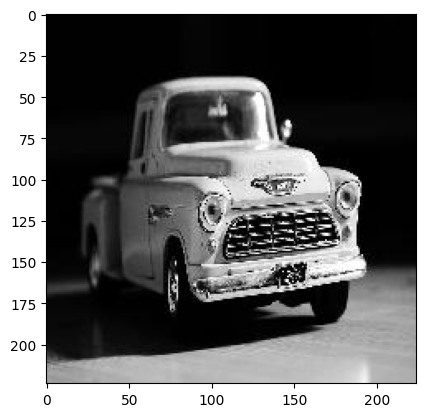

In [7]:
im = cv2.imread("Emergency_Vehicles/train/1002.jpg")
plt.imshow(im)

In [9]:
eff_net = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [12]:
from keras.preprocessing.image import ImageDataGenerator

In [13]:
#datagen=ImageDataGenerator(rescale=1./255)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # range (0-180) within which to randomly rotate pictures
    width_shift_range=0.2,  # fraction of total width to randomly translate pictures
    height_shift_range=0.2, # fraction of total height to randomly translate pictures
    shear_range=0.2,        # randomly applying shear transformations
    zoom_range=0.2,         # randomly zooming inside pictures
    horizontal_flip=True,   # randomly flipping half of the images horizontally
    fill_mode='nearest'     # strategy used for filling in newly created pixels
)

batch_size=150

In [14]:
train_df.emergency_or_not=train_df.emergency_or_not.astype(str)

In [15]:
train_generator=datagen.flow_from_dataframe(dataframe=train_df[:1150],directory=train_dir,x_col='image_names',
                                            y_col='emergency_or_not',class_mode='binary',batch_size=batch_size,
                                            target_size=(64,64))


validation_generator=datagen.flow_from_dataframe(dataframe=train_df[1151:],directory=train_dir,x_col='image_names',
                                                y_col='emergency_or_not',class_mode='binary',batch_size=50,
                                                target_size=(64,64))

Found 1150 validated image filenames belonging to 2 classes.
Found 495 validated image filenames belonging to 2 classes.


In [17]:
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout

efficient_net = efn.EfficientNetB7(
    weights='imagenet',
    input_shape=(64,64,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dropout(0.5))  # randomly sets 50% of input units to 0 at each update during training time
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dropout(0.5))  # randomly sets 50% of input units to 0 at each update during training time
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functional  (None, 2560)             64097680  
 )                                                               
                                                                 
 dense_3 (Dense)             (None, 120)               307320    
                                                                 
 dropout_2 (Dropout)         (None, 120)               0         
                                                                 
 dense_4 (Dense)             (None, 120)               14520     
                                                                 
 dropout_3 (Dropout)         (None, 120)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 121       
                                                      

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
%%time
# Train model
'''history = model.fit(
    train_generator,
    epochs = 50,
    steps_per_epoch = 8,
    validation_data = validation_generator,
    validation_steps = 7
)'''

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # stop training after the validation loss stops improving for 5 epochs
history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=8,
    validation_data=validation_generator,
    validation_steps=7,
    callbacks=[early_stop]  # early stopping
)


Epoch 1/50
8/8 [==============================] - 54s 1s/step - loss: 0.9065 - accuracy: 0.4600 - val_loss: 0.7979 - val_accuracy: 0.3943
Epoch 2/50
8/8 [==============================] - 5s 587ms/step - loss: 0.7800 - accuracy: 0.5052 - val_loss: 0.8090 - val_accuracy: 0.4257
Epoch 3/50
8/8 [==============================] - 6s 717ms/step - loss: 0.7730 - accuracy: 0.5035 - val_loss: 0.8239 - val_accuracy: 0.4000
Epoch 4/50
8/8 [==============================] - 5s 586ms/step - loss: 0.7566 - accuracy: 0.5287 - val_loss: 0.7736 - val_accuracy: 0.4200
Epoch 5/50
8/8 [==============================] - 5s 597ms/step - loss: 0.7351 - accuracy: 0.5426 - val_loss: 0.7616 - val_accuracy: 0.3886
Epoch 6/50
8/8 [==============================] - 5s 593ms/step - loss: 0.7266 - accuracy: 0.5383 - val_loss: 0.7262 - val_accuracy: 0.4057
Epoch 7/50
8/8 [==============================] - 4s 554ms/step - loss: 0.7136 - accuracy: 0.5461 - val_loss: 0.7064 - val_accuracy: 0.4571
Epoch 8/50
8/8 [======

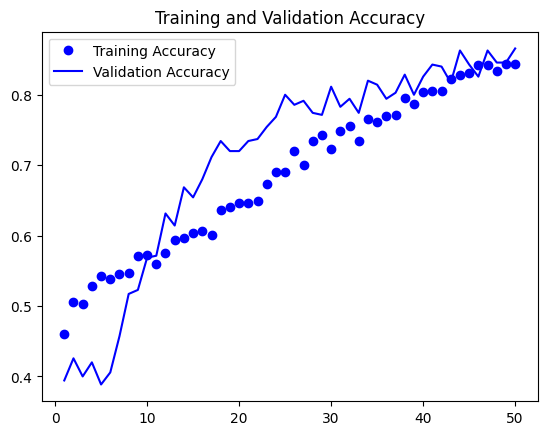

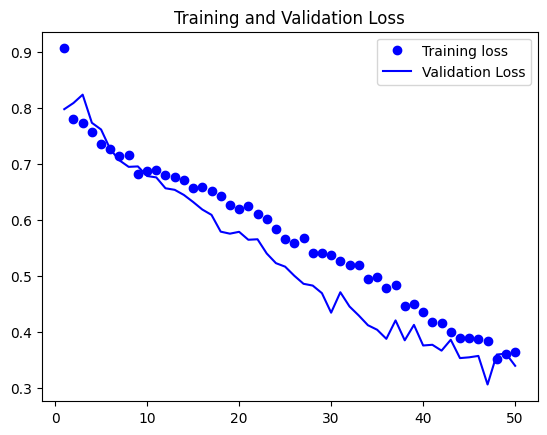

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [22]:
test_df = pd.read_csv('Emergency_Vehicles/test.csv')

test_datagen = ImageDataGenerator(
    rescale=1/255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = test_dir,
    x_col="image_names",
    target_size=(64,64),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

Found 706 validated image filenames.


In [23]:
preds = model.predict_generator(
    test_generator,
    steps=len(test_generator.filenames)
)

<ipython-input-23-224ef71c1eac>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(


In [24]:
preds

array([[1.89554691e-02],
       [7.00664043e-01],
       [2.60181514e-05],
       [8.67926717e-01],
       [3.00593744e-03],
       [7.34471142e-01],
       [5.54340839e-01],
       [9.85649407e-01],
       [6.08014800e-02],
       [2.96153545e-01],
       [3.77802588e-02],
       [1.61853991e-02],
       [2.14542627e-01],
       [2.14149198e-03],
       [4.18592244e-02],
       [9.92259085e-01],
       [1.74190640e-01],
       [3.47169548e-01],
       [2.66050309e-01],
       [8.71020436e-01],
       [9.60559666e-01],
       [1.26916952e-02],
       [7.53334105e-01],
       [4.83413601e-07],
       [4.69755905e-04],
       [3.01858112e-02],
       [4.89058882e-01],
       [5.58913760e-02],
       [1.04973849e-03],
       [7.43195772e-01],
       [9.83269215e-01],
       [2.59145367e-04],
       [4.89135414e-01],
       [7.01618774e-05],
       [7.40257977e-03],
       [3.93890254e-02],
       [3.58015625e-03],
       [9.97798979e-01],
       [3.36309411e-02],
       [6.59441575e-02],


In [25]:
image_ids = [name.split('/')[-1] for name in test_generator.filenames]
predictions = preds.flatten()
data = {'image_names': image_ids, 'emergency_or_not':predictions}
submission = pd.DataFrame(data)
print(submission.head())

  image_names  emergency_or_not
0    1960.jpg          0.018955
1     668.jpg          0.700664
2    2082.jpg          0.000026
3     808.jpg          0.867927
4    1907.jpg          0.003006


In [26]:
submission['emergency_or_not'] = submission['emergency_or_not'].apply(lambda x: 1 if x > 0.75 else 0)


In [27]:
submission.to_csv('submission_effnet.csv',index=False)
